# Traffic Sign Recognition

The Dataset: 

# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [2]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [3]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [4]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot a test image

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# plot kernel weights

def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_filters (model):
    for layer in model.layers:
        if 'conv' in layer.name:
            weights, bias= layer.get_weights()
            #print(layer.name, filters.shape)
            
            #normalize filter values between  0 and 1 for visualization
            f_min, f_max = weights.min(), weights.max()
            filters = (weights - f_min) / (f_max - f_min)  
            print(filters.shape[3])
            filter_cnt=1
            
            #plotting all the filters
            for i in range(filters.shape[3]):
                #get the filters
                filt=filters[:,:,:, i]
                #plotting each of the channel, color image RGB channels
                for j in range(filters.shape[0]):
                    ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(filt[:, j])
                    filter_cnt+=1
            plt.show()  

## MLOps

Weights an Biases init

In [5]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [6]:
#Generic dataset parameters
img_width, img_height = 64, 64
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

## Simple Keras based data augmentation

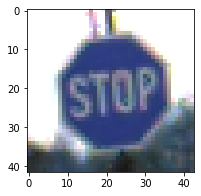

In [7]:
# loading an image sample
img = get_input_img(sign_class=14, img_height=img_height, img_width=img_width, index=31, dataset='Train')

def plot_augmented_samples (batch):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    # generate batch of images
    for i in range(3):
	    # convert to unsigned integers
	    image = next(aug_iter)[0].astype('uint8')
	    # plot image
	    ax[i].imshow(image)
	    ax[i].axis('off')
    

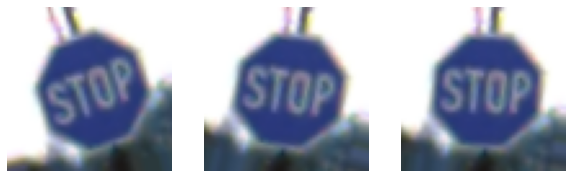

In [8]:
# image rotation
datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

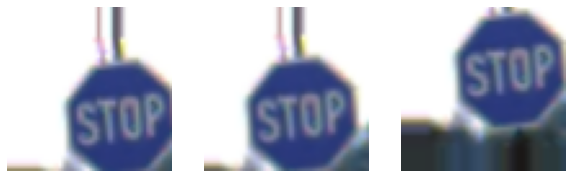

In [9]:
# height and width of the image
datagen = ImageDataGenerator(width_shift_range=.2, 
        height_shift_range=.2,
        fill_mode='nearest'
        )
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

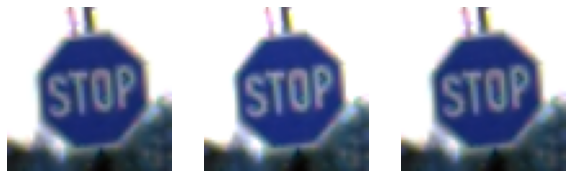

In [10]:
# brightness
datagen = ImageDataGenerator(brightness_range=[1,1.2])
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

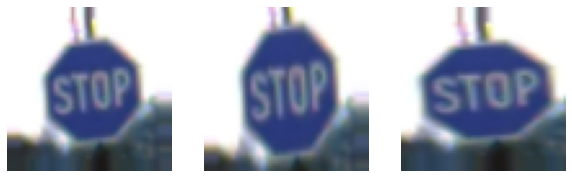

In [11]:
# zoom
datagen = ImageDataGenerator(zoom_range=0.2)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


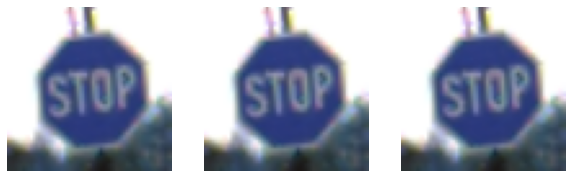

In [12]:
# ZCA whitening
datagen = ImageDataGenerator(zca_whitening=True)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

NOTE:
- We opt not to use zoom as it will distort the sign shapes
- We also opt not to horizontal and vertical flips and signs have directional information which would be lost

Found 27447 images belonging to 43 classes.


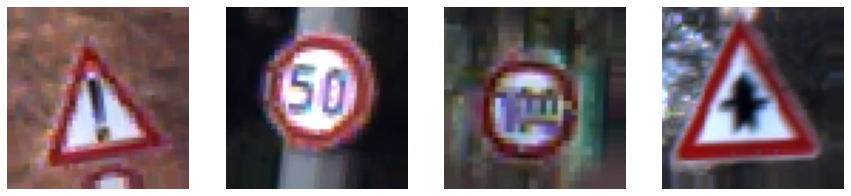

In [13]:
# dry running the generator and fine-tunning the parameters

train_datagen = ImageDataGenerator(validation_split=0.3, 
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=10,
    # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
    width_shift_range=.1, 
    height_shift_range=.1,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2]
    # zoom
    #zoom_range=0.2,
    #zca_whitening
    )
        
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    class_mode='categorical'
    )

# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')


In [14]:
# training dataset
# With Keras data augmentation

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
        #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, 
        # we will not use vertical/horizontal flip as signs have directional information that is revelant
        # adding a img rotation of up to 20º
        rotation_range=20,
        # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
        width_shift_range=.1, 
        height_shift_range=.1,
        fill_mode='nearest',
        # adding a brightness range of 1 to 1.2 - after visual inspection
        brightness_range=[1,1.2],
        # zoom
        #zoom_range=0.2,
        rescale=1./255)
        
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[1,1.2]
        )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False
        )
    
    return test_generator

In [15]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [16]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


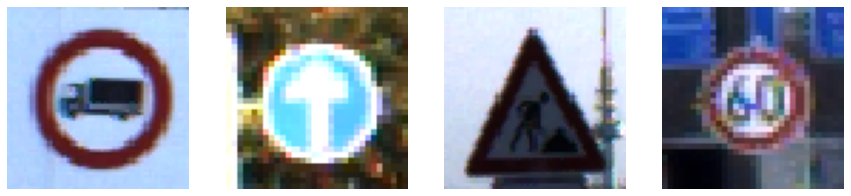

In [17]:
# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(test_generator)[0]

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

In [18]:
print (train_generator.next()[0])

[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.1254902  0.11764707 0.14509805]
   [0.13333334 0.11764707 0.14901961]
   [0.13333334 0.11764707 0.14117648]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.12941177 0.1254902  0.15294118]
   [0.13333334 0.11764707 0.14509805]
   [0.12941177 0.1137255  0.14117648]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.11764707 0.10980393 0.14509805]
   [0.1254902  0.10980393 0.14117648]
   [0.11764707 0.10588236 0.13725491]]

  ...

  [[0.07450981 0.0627451  0.08235294]
   [0.07450981 0.0627451  0.08235294]
   [0.07450981 0.0627451  0.08235294]
   ...
   [0.09803922 0.09411766 0.1254902 ]
   [0.09803922 0.09411766 0.11764707]
   [0.09803922 0.09411766 0.11764707]]

  [[0.08627451 0.06666667 0.08235294]
   [0.0

In [19]:
print (test_generator.next()[0])


[[[[0.3019608  0.21960786 0.2509804 ]
   [0.3019608  0.21960786 0.2509804 ]
   [0.36078432 0.30588236 0.3254902 ]
   ...
   [0.3647059  0.24705884 0.27058825]
   [0.40784317 0.3254902  0.34117648]
   [0.40784317 0.3254902  0.34117648]]

  [[0.3019608  0.21960786 0.2509804 ]
   [0.3019608  0.21960786 0.2509804 ]
   [0.36078432 0.30588236 0.3254902 ]
   ...
   [0.3647059  0.24705884 0.27058825]
   [0.40784317 0.3254902  0.34117648]
   [0.40784317 0.3254902  0.34117648]]

  [[0.29803923 0.2392157  0.27450982]
   [0.29803923 0.2392157  0.27450982]
   [0.3372549  0.29803923 0.32156864]
   ...
   [0.24705884 0.18823531 0.19215688]
   [0.27058825 0.22352943 0.21176472]
   [0.27058825 0.22352943 0.21176472]]

  ...

  [[0.9333334  0.5568628  0.42352945]
   [0.9333334  0.5568628  0.42352945]
   [0.75294125 0.427451   0.3647059 ]
   ...
   [0.14509805 0.1254902  0.15686275]
   [0.15686275 0.15686275 0.18431373]
   [0.15686275 0.15686275 0.18431373]]

  [[0.8470589  0.5058824  0.48235297]
   [0.8

In [20]:
print('Batches train=%d, test=%d' % (len(train_generator), len(test_generator)))

Batches train=108, test=50


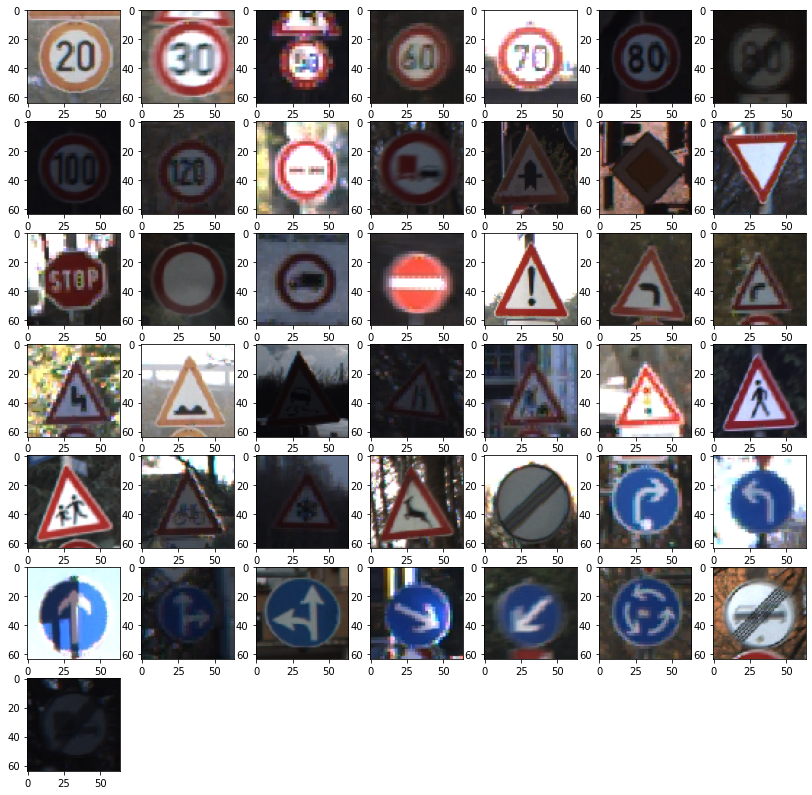

In [21]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [22]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

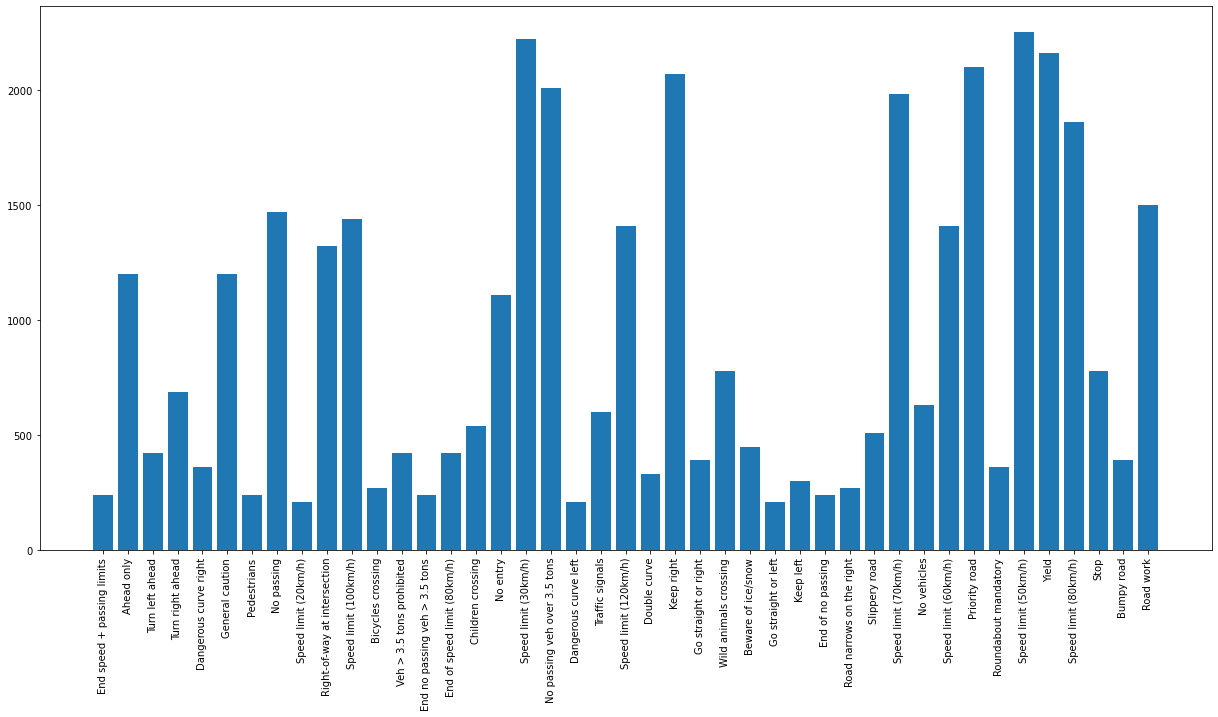

In [23]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [24]:
# Calculating the weights to compensate for the class imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 4.342192691029901,
 1: 0.4107479572595852,
 2: 0.45366192294342245,
 3: 0.6908033826638478,
 4: 0.43421926910299,
 5: 0.4221576227390181,
 6: 1.1690518783542039,
 7: 1.4473975636766334,
 8: 2.1710963455149503,
 9: 0.8214959145191704,
 10: 0.7598837209302326,
 11: 4.342192691029901,
 12: 0.40527131782945736,
 13: 2.5329457364341086,
 14: 2.763213530655391,
 15: 2.3381037567084078,
 16: 1.7879616963064295,
 17: 3.3772609819121446,
 18: 0.607906976744186,
 19: 1.5197674418604652,
 20: 3.7994186046511627,
 21: 1.6886304909560723,
 22: 3.3772609819121446,
 23: 0.6467095497278575,
 24: 2.026356589147287,
 25: 1.1690518783542039,
 26: 3.7994186046511627,
 27: 1.321536905965622,
 28: 2.1710963455149503,
 29: 0.7598837209302326,
 30: 2.3381037567084078,
 31: 4.342192691029901,
 32: 0.44051230198854063,
 33: 3.0395348837209304,
 34: 0.4605355884425652,
 35: 2.5329457364341086,
 36: 3.7994186046511627,
 37: 3.7994186046511627,
 38: 0.49024756189047264,
 39: 2.1710963455149503,
 40: 0.63323643

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [25]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [26]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                             

2022-01-27 14:33:56.157485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-27 14:33:56.157581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Training And Evaluating The Model

In [27]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

In [28]:
from tensorflow.keras import optimizers 
# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

baseline_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [29]:
# Common attributes:
mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc', 'f1']

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [31]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline_b256_e100_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


2022-01-27 14:34:00.643182: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-01-27 14:34:00.946114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 2.7452 - acc: 0.2120 - f1_score: 0.2196

2022-01-27 14:34:21.908094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 26s 255ms/step - loss: 2.7452 - acc: 0.2120 - f1_score: 0.2196 - val_loss: 2.4192 - val_acc: 0.2869 - val_f1_score: 0.2721
Epoch 2/100
100/100 [==============================] - 25s 251ms/step - loss: 1.8911 - acc: 0.3969 - f1_score: 0.3940 - val_loss: 2.1925 - val_acc: 0.3383 - val_f1_score: 0.3298
Epoch 3/100
100/100 [==============================] - 25s 251ms/step - loss: 1.5303 - acc: 0.4801 - f1_score: 0.4769 - val_loss: 2.2489 - val_acc: 0.3729 - val_f1_score: 0.3655
Epoch 4/100
100/100 [==============================] - 25s 252ms/step - loss: 1.2504 - acc: 0.5517 - f1_score: 0.5514 - val_loss: 1.9064 - val_acc: 0.4551 - val_f1_score: 0.4544
Epoch 5/100
100/100 [==============================] - 25s 251ms/step - loss: 1.0563 - acc: 0.6122 - f1_score: 0.6134 - val_loss: 1.8453 - val_acc: 0.4791 - val_f1_score: 0.4839
Epoch 6/100
100/100 [==============================] - 25s 252ms/step - loss: 0.9580 - acc: 0.6428 - f1_score: 0.6449 - va

/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


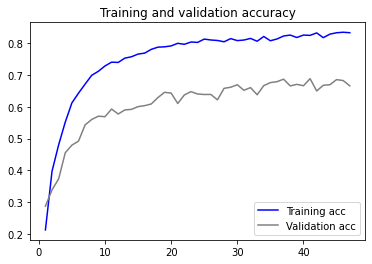

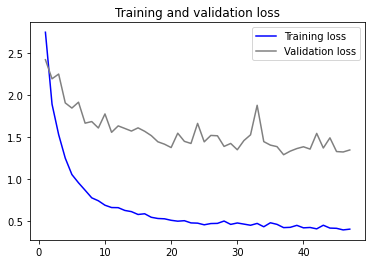

In [32]:
plot_results(history_baseline)

2022-01-27 14:56:41.896328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[  6   4   0 ...   5  41   0]
 [ 15 471   0 ...  32  39   0]
 [  0   0 581 ...   2   6  11]
 ...
 [  0   4   0 ... 301  43   3]
 [  5   5   2 ...  80 291   5]
 [  0   0 114 ...   0   0 343]]


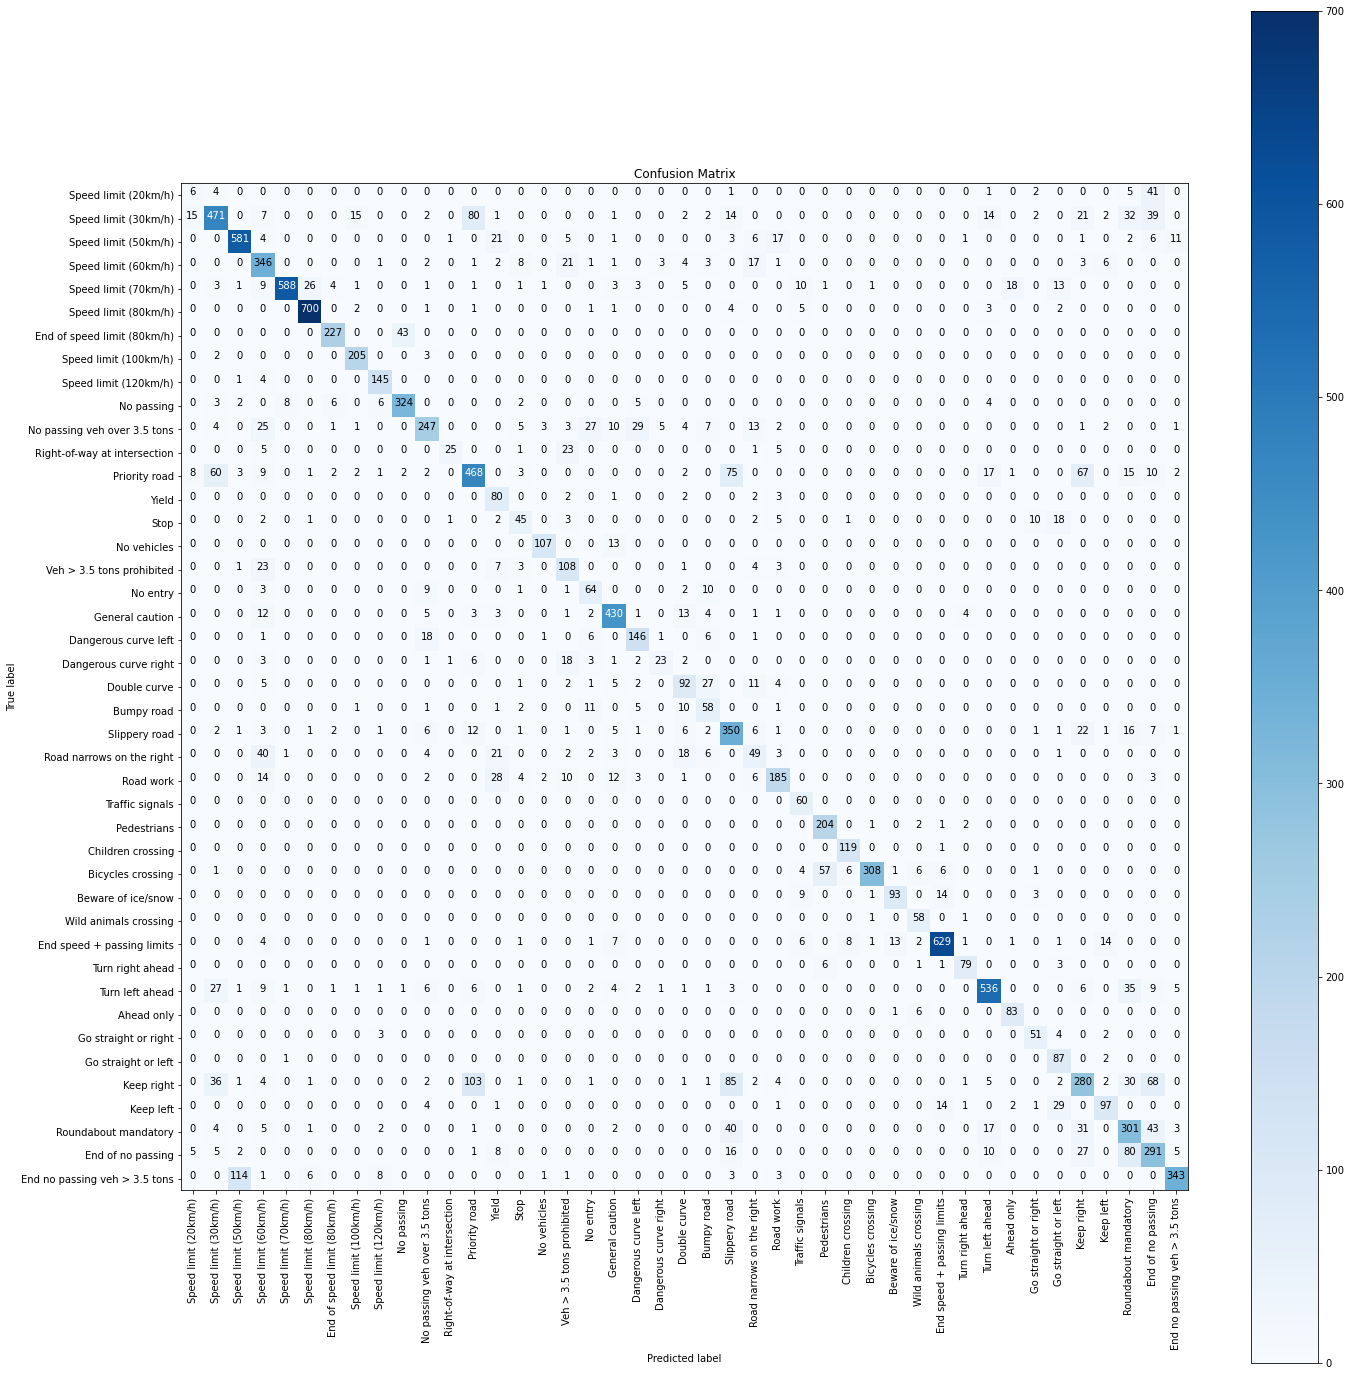

In [33]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [34]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.10      0.18      0.13        34
         Speed limit (30km/h)       0.65      0.76      0.70       622
         Speed limit (50km/h)       0.88      0.82      0.85       708
         Speed limit (60km/h)       0.82      0.64      0.72       538
         Speed limit (70km/h)       0.85      0.98      0.91       599
         Speed limit (80km/h)       0.97      0.95      0.96       737
  End of speed limit (80km/h)       0.84      0.93      0.88       243
        Speed limit (100km/h)       0.98      0.90      0.94       228
        Speed limit (120km/h)       0.97      0.86      0.91       168
                   No passing       0.90      0.88      0.89       370
 No passing veh over 3.5 tons       0.63      0.78      0.70       317
 Right-of-way at intersection       0.42      0.89      0.57        28
                Priority road       0.62      0.69      0.65       683
     

Shape before entering the conv layer: (1, 64, 64, 3)


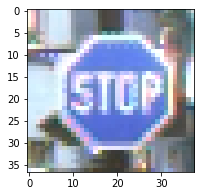

In [35]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 31, 31, 32)
(1, 29, 29, 32)
(1, 14, 14, 32)
(1, 6272)
(1, 128)
(1, 43)


2022-01-27 14:56:48.763246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


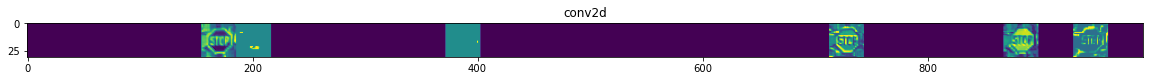

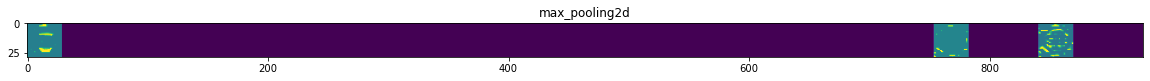

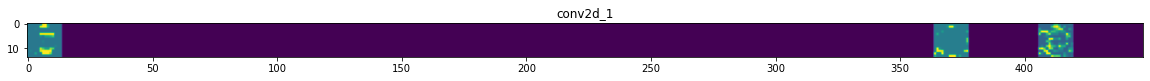

In [36]:
plot_feature_maps(baseline_model, img)

## 7 layer model

Refference: Masci, et al "A committee of neural networks for traffic sign classification" [1]

In [37]:
masci_model = Sequential()
# Refference: DLNN lecture week 6
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (4, 4), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
masci_model.add(Flatten())
# MLP - hidden layer
masci_model.add(Dense(units=200, activation=relu))
# MLP - output layer
masci_model.add(Dense(units=43, activation=softmax))

# Check built model:
masci_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)        

In [38]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

masci_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [39]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [41]:
# MLOps init and callback
wandb.init(name='CNN_TS_masci_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_masci_model = masci_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100


2022-01-27 14:57:00.912146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 3.7734 - acc: 0.0164 - f1_score: 0.0081

2022-01-27 14:57:23.334341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 28s 271ms/step - loss: 3.7734 - acc: 0.0164 - f1_score: 0.0081 - val_loss: 3.7712 - val_acc: 0.0094 - val_f1_score: 1.7415e-04
Epoch 2/100
100/100 [==============================] - 26s 258ms/step - loss: 3.7532 - acc: 0.0126 - f1_score: 0.0022 - val_loss: 3.7664 - val_acc: 0.0111 - val_f1_score: 2.4515e-04
Epoch 3/100
100/100 [==============================] - 26s 261ms/step - loss: 3.7591 - acc: 0.0202 - f1_score: 0.0104 - val_loss: 3.7624 - val_acc: 0.0109 - val_f1_score: 2.3667e-04
Epoch 4/100
100/100 [==============================] - 26s 261ms/step - loss: 3.7588 - acc: 0.0163 - f1_score: 0.0070 - val_loss: 3.7578 - val_acc: 0.0492 - val_f1_score: 0.0046
Epoch 5/100
100/100 [==============================] - 26s 259ms/step - loss: 3.7517 - acc: 0.0244 - f1_score: 0.0100 - val_loss: 3.7559 - val_acc: 0.0287 - val_f1_score: 0.0016
Epoch 6/100
100/100 [==============================] - 26s 260ms/step - loss: 3.7658 - acc: 0.0194 - f1_score:

/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


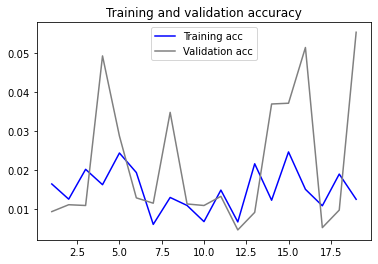

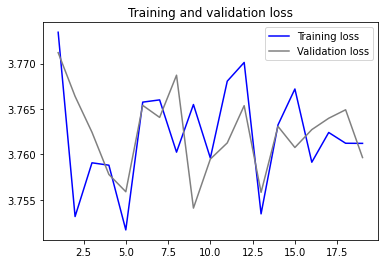

In [42]:
plot_results(history_masci_model)

2022-01-27 15:05:25.626994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


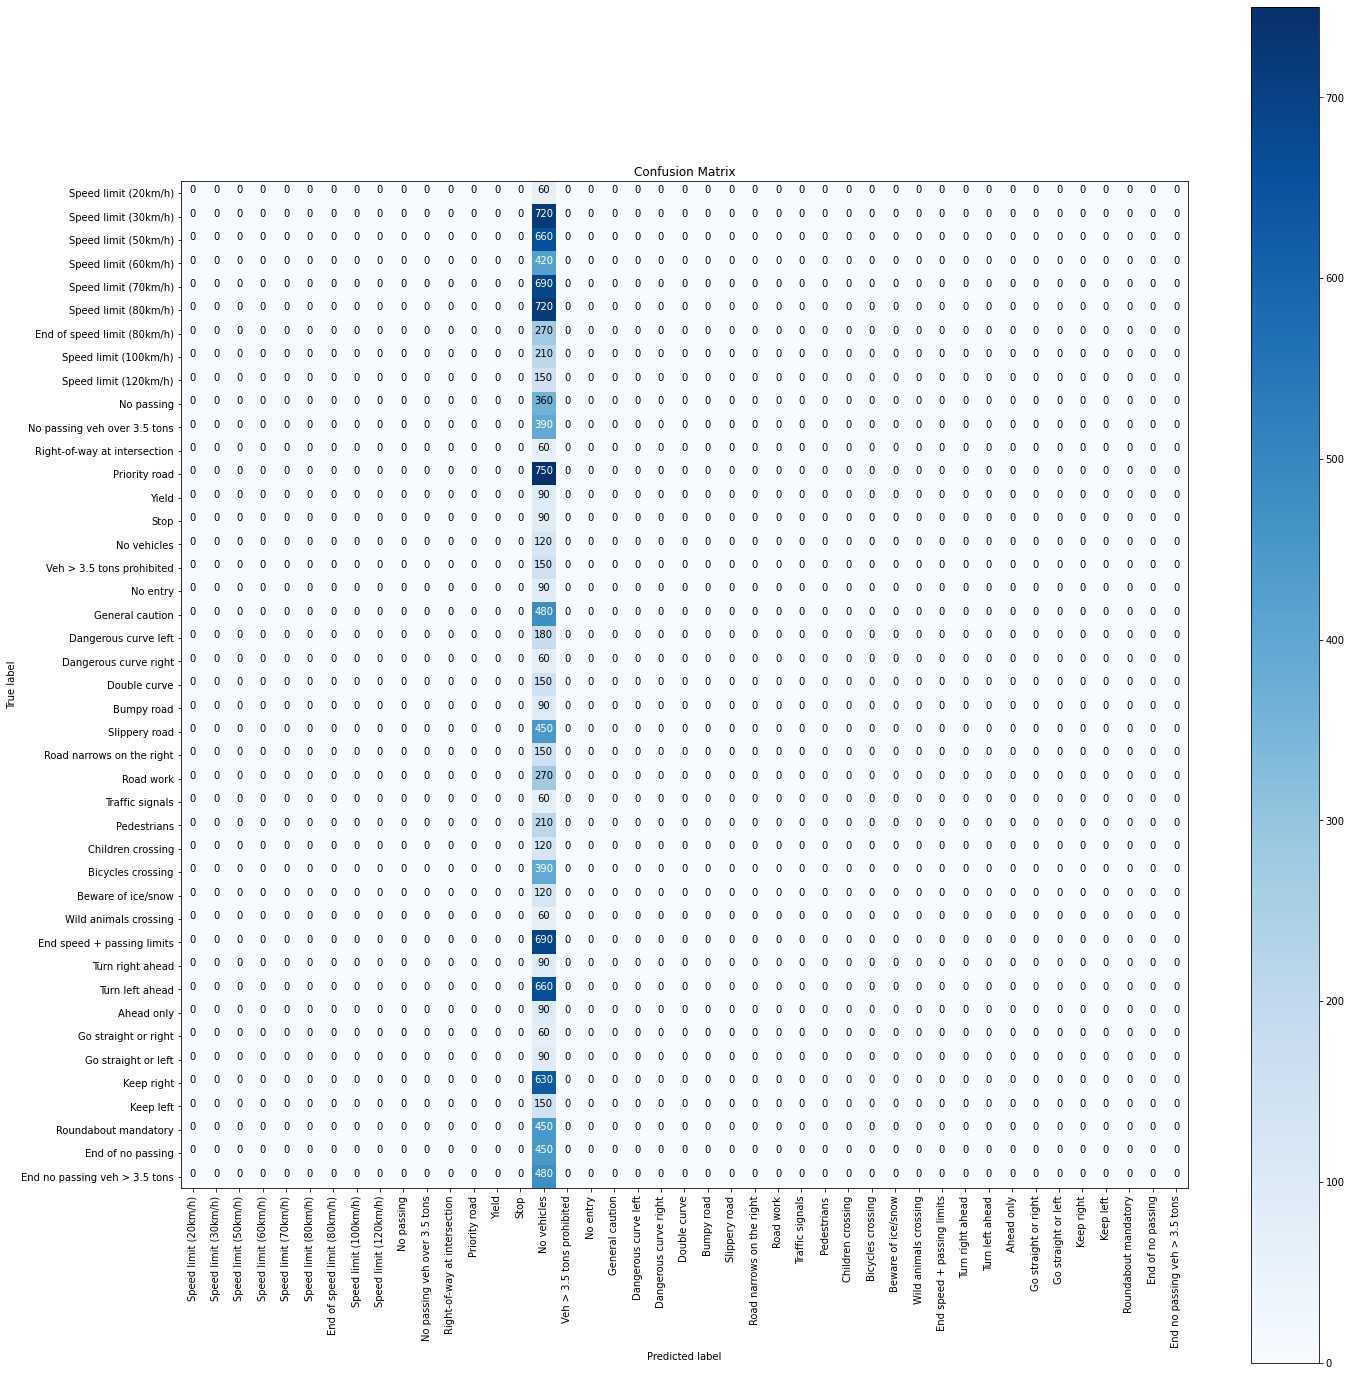

In [43]:
# predictions on Test data

Y_pred = masci_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [44]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00         0
         Speed limit (30km/h)       0.00      0.00      0.00         0
         Speed limit (50km/h)       0.00      0.00      0.00         0
         Speed limit (60km/h)       0.00      0.00      0.00         0
         Speed limit (70km/h)       0.00      0.00      0.00         0
         Speed limit (80km/h)       0.00      0.00      0.00         0
  End of speed limit (80km/h)       0.00      0.00      0.00         0
        Speed limit (100km/h)       0.00      0.00      0.00         0
        Speed limit (120km/h)       0.00      0.00      0.00         0
                   No passing       0.00      0.00      0.00         0
 No passing veh over 3.5 tons       0.00      0.00      0.00         0
 Right-of-way at intersection       0.00      0.00      0.00         0
                Priority road       0.00      0.00      0.00         0
     

/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Shape before entering the conv layer: (1, 64, 64, 3)


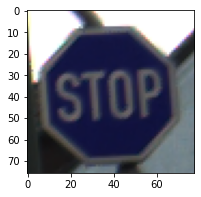

In [45]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

2022-01-27 15:05:32.134281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


(1, 31, 31, 32)
(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 200)
(1, 43)


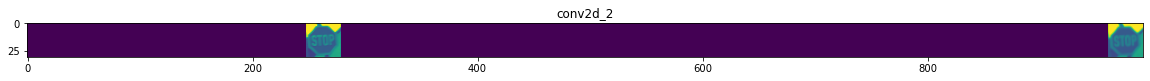

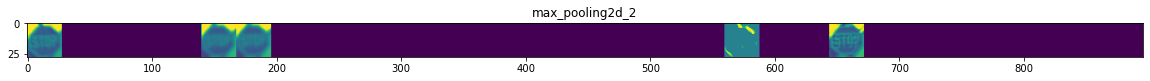

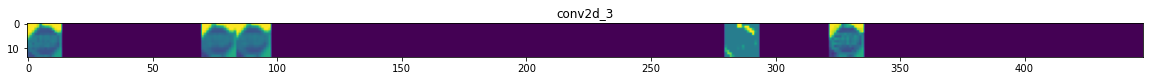

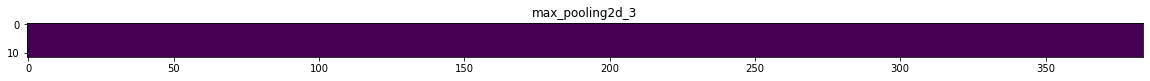

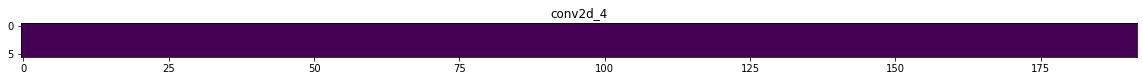

In [46]:
plot_feature_maps(masci_model, img)


## Small Scale Model

Refference: Chaudhari (et, al) "Traffic Sign Recognition Using Small-Scale Convolutional Neural Network"

In [47]:
lwm_model = Sequential()
# MLP - input layer
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
# MLP layer
lwm_model.add(Flatten())
lwm_model.add(Dense(units=256, activation=relu))
lwm_model.add(Dropout(0.25))
lwm_model.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                  

In [48]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 1000
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc', 'f1']
mlops_config['learning_rate'] = 0.01


In [49]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

masci_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [50]:
from tensorflow.keras import optimizers 

lwm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [52]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm_b256_e100_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model = lwm_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/1000


2022-01-27 15:05:37.266759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 2.9054 - acc: 0.1824 - f1_score: 0.1891

2022-01-27 15:06:02.243735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 31s 305ms/step - loss: 2.9054 - acc: 0.1824 - f1_score: 0.1891 - val_loss: 2.3340 - val_acc: 0.3205 - val_f1_score: 0.3070
Epoch 2/1000
100/100 [==============================] - 31s 312ms/step - loss: 1.7237 - acc: 0.4441 - f1_score: 0.4445 - val_loss: 2.0325 - val_acc: 0.3842 - val_f1_score: 0.3951
Epoch 3/1000
100/100 [==============================] - 37s 373ms/step - loss: 1.2497 - acc: 0.5681 - f1_score: 0.5694 - val_loss: 1.7253 - val_acc: 0.4811 - val_f1_score: 0.4858
Epoch 4/1000
100/100 [==============================] - 36s 357ms/step - loss: 0.9443 - acc: 0.6504 - f1_score: 0.6514 - val_loss: 1.5302 - val_acc: 0.5561 - val_f1_score: 0.5601
Epoch 5/1000
100/100 [==============================] - 34s 337ms/step - loss: 0.7414 - acc: 0.7118 - f1_score: 0.7125 - val_loss: 1.3651 - val_acc: 0.6125 - val_f1_score: 0.6117
Epoch 6/1000
100/100 [==============================] - 33s 328ms/step - loss: 0.6062 - acc: 0.7557 - f1_score: 0.7564

/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


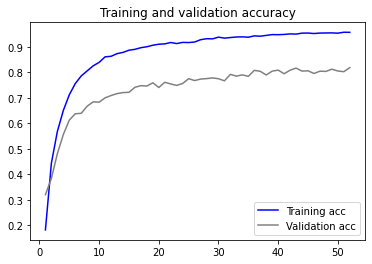

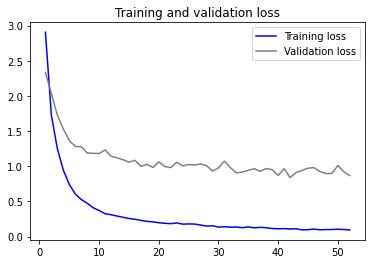

In [53]:
plot_results(history_lwm_model)

2022-01-27 15:34:13.507796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[  5  22   0 ...   0  12   0]
 [  3 575   0 ...   4   4   0]
 [  0   0 634 ...   0   5   1]
 ...
 [  0   0   0 ... 343  72   0]
 [  0   0   0 ...  14 359   0]
 [  0   0  35 ...   2   1 422]]


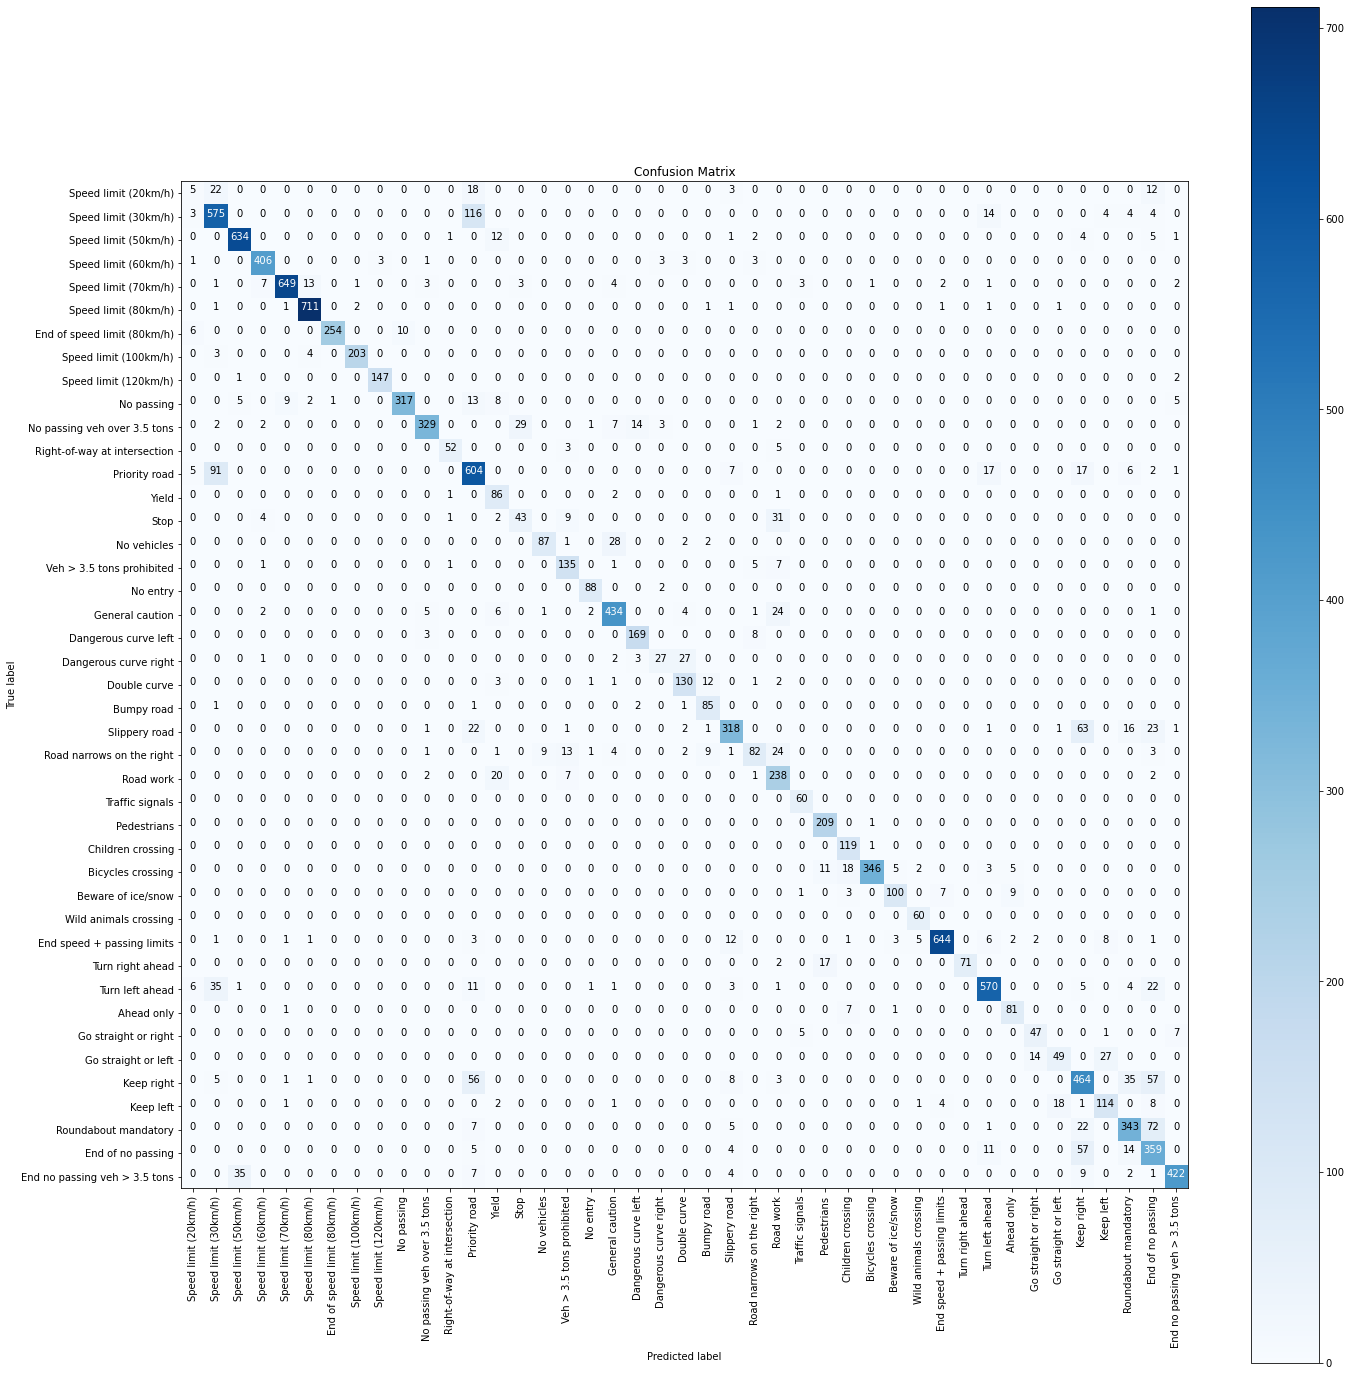

In [54]:
# predictions on Test data

Y_pred = lwm_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [55]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.08      0.19      0.12        26
         Speed limit (30km/h)       0.80      0.78      0.79       737
         Speed limit (50km/h)       0.96      0.94      0.95       676
         Speed limit (60km/h)       0.97      0.96      0.96       423
         Speed limit (70km/h)       0.94      0.98      0.96       663
         Speed limit (80km/h)       0.99      0.97      0.98       732
  End of speed limit (80km/h)       0.94      1.00      0.97       255
        Speed limit (100km/h)       0.97      0.99      0.98       206
        Speed limit (120km/h)       0.98      0.98      0.98       150
                   No passing       0.88      0.97      0.92       327
 No passing veh over 3.5 tons       0.84      0.95      0.90       345
 Right-of-way at intersection       0.87      0.93      0.90        56
                Priority road       0.81      0.70      0.75       863
     

Shape before entering the conv layer: (1, 64, 64, 3)


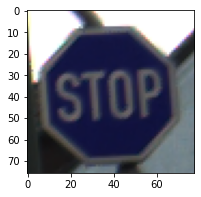

In [56]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 60, 60, 32)
(1, 30, 30, 32)
(1, 30, 30, 32)
(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(1, 6272)
(1, 256)
(1, 256)
(1, 43)


2022-01-27 15:34:20.293911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


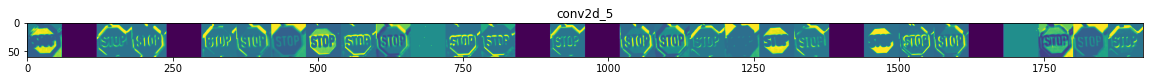

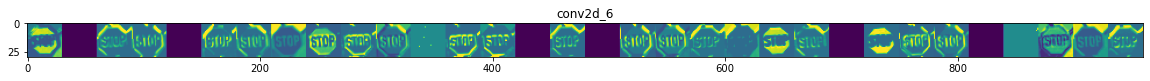

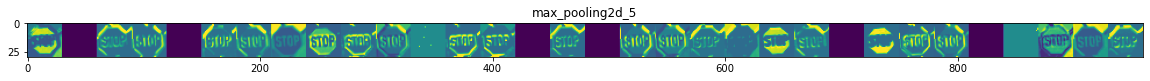

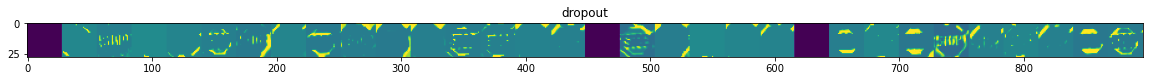

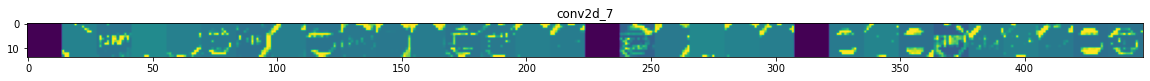

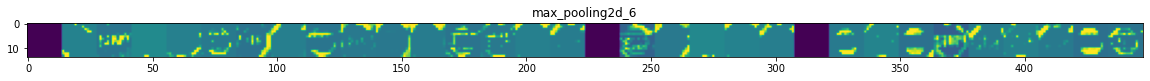

In [57]:
plot_feature_maps(lwm_model, img)

### Improving on LWM

In [58]:
lwm_model2 = Sequential()
# MLP - input layer
lwm_model2.add(Conv2D(filters=8, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model2.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(Conv2D(filters=32, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(Conv2D(filters=64, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Dropout(0.25))
# MLP layer
lwm_model2.add(Flatten())
lwm_model2.add(Dense(units=256, activation=relu))
lwm_model2.add(Dropout(0.25))
lwm_model2.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 60, 60, 8)         608       
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 16)        3216      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 16)        6416      
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 32)        12832     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                  

In [59]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

lwm_model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [60]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 50
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [61]:
from tensorflow.keras import optimizers 

lwm_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [63]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm2_b256_e50_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm2_model = lwm_model2.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/50


2022-01-27 15:34:25.812213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 3.2418 - acc: 0.1376 - f1_score: 0.1404

2022-01-27 15:34:50.699589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 31s 303ms/step - loss: 3.2418 - acc: 0.1376 - f1_score: 0.1404 - val_loss: 2.2140 - val_acc: 0.3082 - val_f1_score: 0.2908
Epoch 2/50
100/100 [==============================] - 32s 315ms/step - loss: 1.7471 - acc: 0.4411 - f1_score: 0.4460 - val_loss: 1.3201 - val_acc: 0.5807 - val_f1_score: 0.5850
Epoch 3/50
100/100 [==============================] - 34s 336ms/step - loss: 0.9980 - acc: 0.6589 - f1_score: 0.6629 - val_loss: 0.8760 - val_acc: 0.7496 - val_f1_score: 0.7526
Epoch 4/50
100/100 [==============================] - 31s 306ms/step - loss: 0.6505 - acc: 0.7730 - f1_score: 0.7758 - val_loss: 0.6162 - val_acc: 0.8178 - val_f1_score: 0.8225
Epoch 5/50
100/100 [==============================] - 30s 299ms/step - loss: 0.4736 - acc: 0.8377 - f1_score: 0.8400 - val_loss: 0.5597 - val_acc: 0.8422 - val_f1_score: 0.8431
Epoch 6/50
100/100 [==============================] - 30s 303ms/step - loss: 0.3580 - acc: 0.8743 - f1_score: 0.8756 - val_los

/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


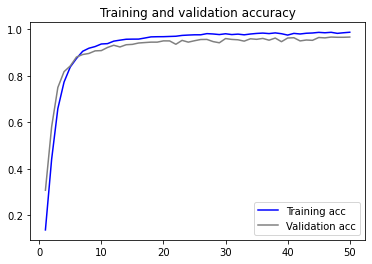

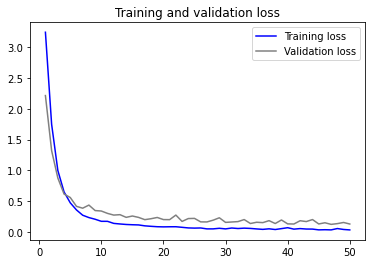

In [64]:
plot_results(history_lwm2_model)

2022-01-27 15:59:54.536500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[ 57   0   0 ...   0   0   0]
 [  0 709   0 ...   0   0   0]
 [  0   0 656 ...   0   0   1]
 ...
 [  0   0   0 ... 449   1   0]
 [  0   0   0 ...   0 447   0]
 [  0   0   0 ...   0   0 480]]


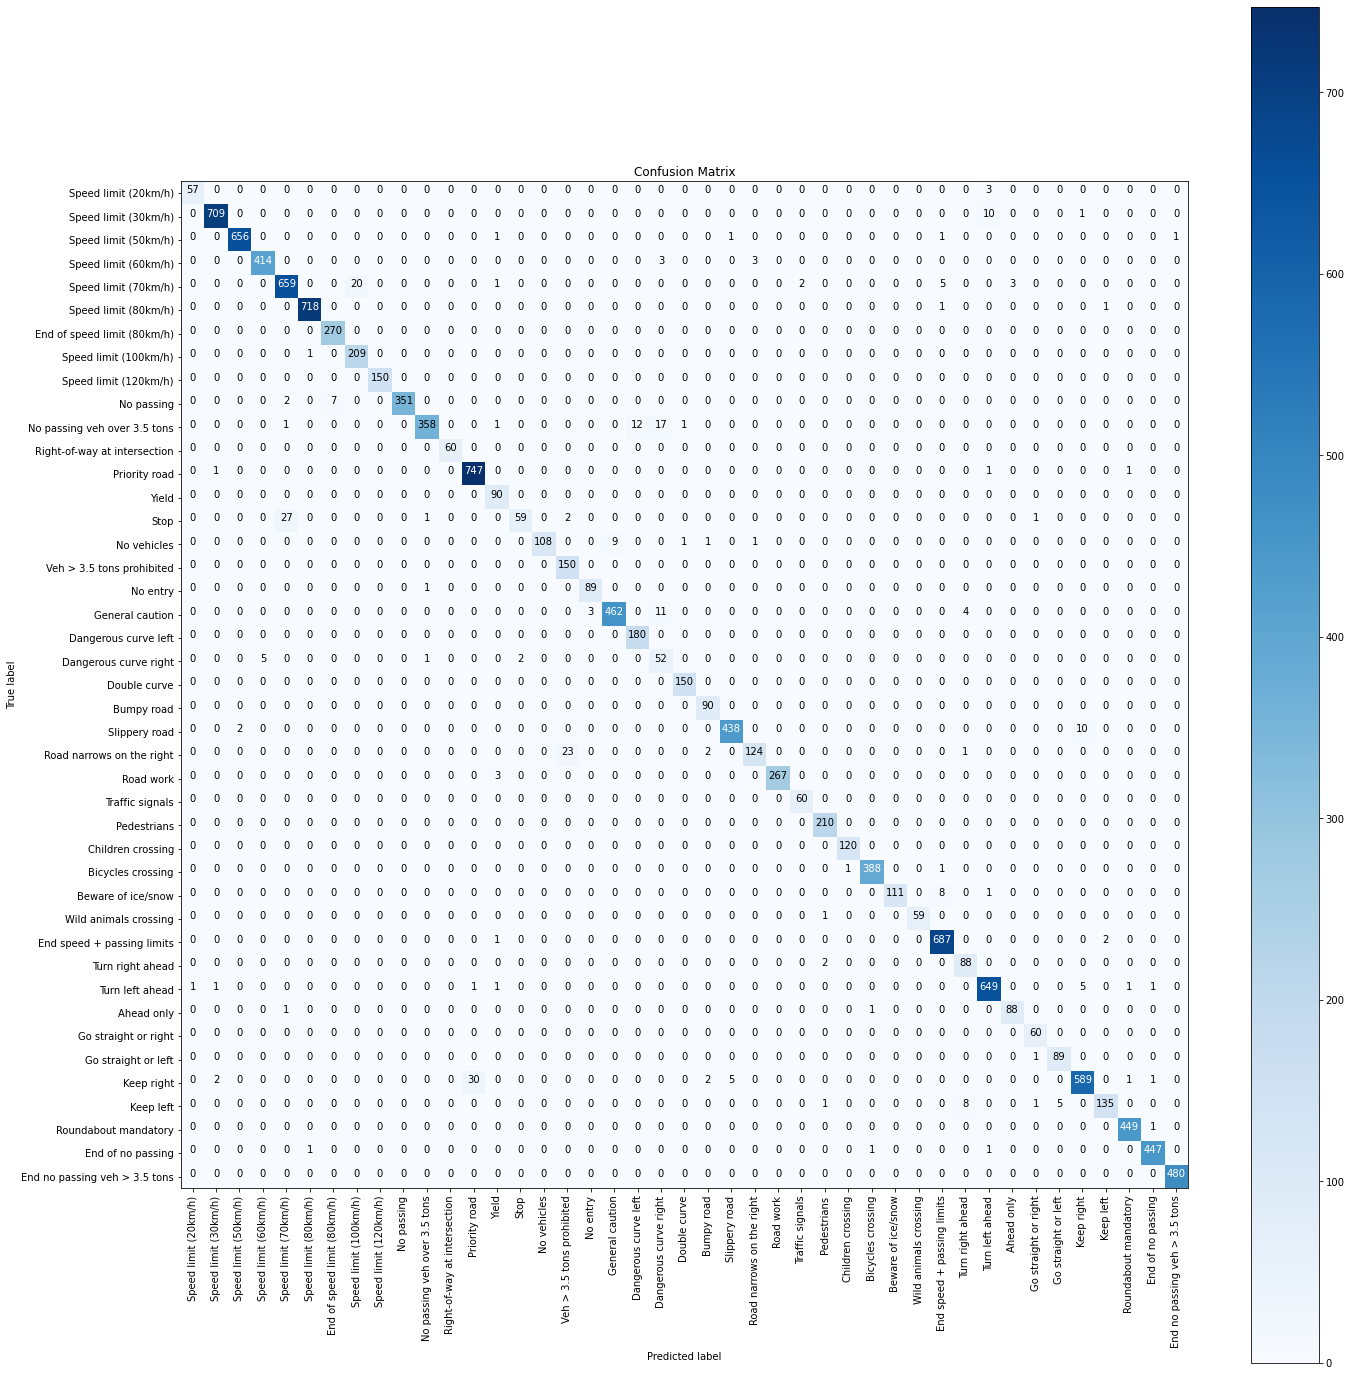

In [65]:
# predictions on Test data

Y_pred = lwm_model2.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [66]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.95      0.98      0.97        58
         Speed limit (30km/h)       0.98      0.99      0.99       713
         Speed limit (50km/h)       0.99      1.00      1.00       658
         Speed limit (60km/h)       0.99      0.99      0.99       419
         Speed limit (70km/h)       0.96      0.96      0.96       690
         Speed limit (80km/h)       1.00      1.00      1.00       720
  End of speed limit (80km/h)       1.00      0.97      0.99       277
        Speed limit (100km/h)       1.00      0.91      0.95       229
        Speed limit (120km/h)       1.00      1.00      1.00       150
                   No passing       0.97      1.00      0.99       351
 No passing veh over 3.5 tons       0.92      0.99      0.95       361
 Right-of-way at intersection       1.00      1.00      1.00        60
                Priority road       1.00      0.96      0.98       778
     

Shape before entering the conv layer: (1, 64, 64, 3)


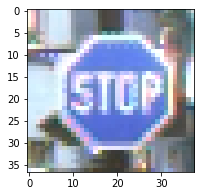

In [67]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

2022-01-27 16:00:01.281547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


(1, 56, 56, 16)
(1, 28, 28, 16)
(1, 24, 24, 16)
(1, 20, 20, 32)
(1, 10, 10, 32)
(1, 8, 8, 32)
(1, 6, 6, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 576)
(1, 256)
(1, 256)
(1, 43)


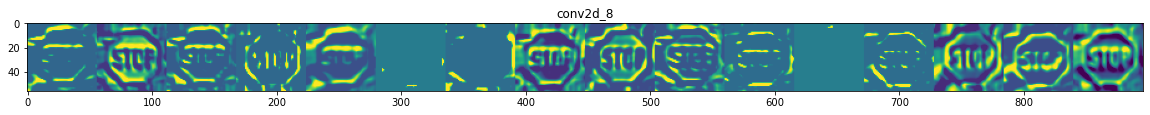

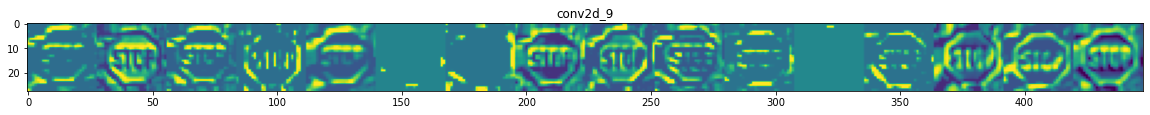

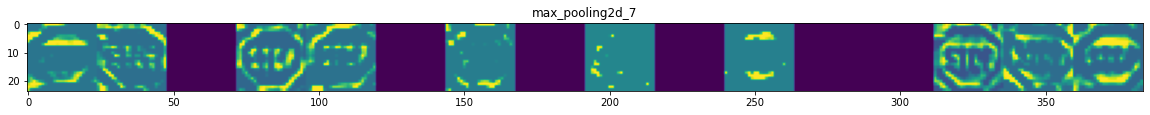

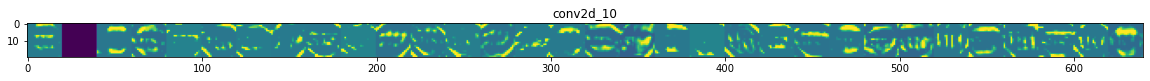

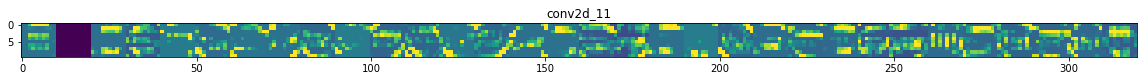

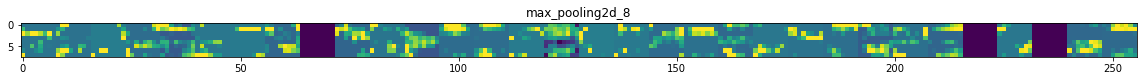

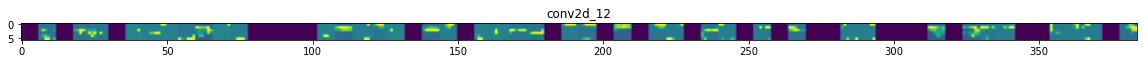

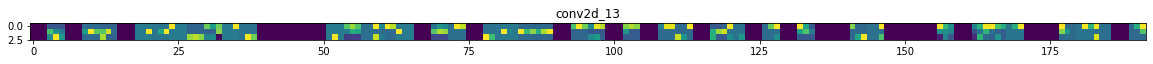

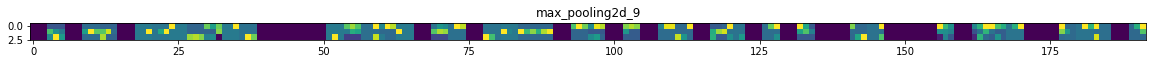

In [68]:
plot_feature_maps(lwm_model2, img)

### Model 3

In [77]:
lwm_model3 = Sequential()
# MLP - input layer
lwm_model3.add(Conv2D(filters=8, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model3.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(Conv2D(filters=32, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Conv2D(filters=64, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(MaxPooling2D(pool_size=(2, 2)))
# MLP layer
lwm_model3.add(Flatten())
lwm_model3.add(Dense(units=1024, activation=relu))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Dense(units=512, activation=relu))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 60, 60, 8)         608       
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 16)        3216      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 24, 24, 16)        6416      
                                                                 
 conv2d_27 (Conv2D)          (None, 20, 20, 32)        12832     
                                                      

In [78]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

lwm_model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [79]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [81]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm3_b256_e50_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model3 = lwm_model3.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100


2022-01-27 16:27:44.324517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 3.7776 - acc: 0.0130 - f1_score: 0.0070

2022-01-27 16:28:08.242556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 29s 291ms/step - loss: 3.7776 - acc: 0.0130 - f1_score: 0.0070 - val_loss: 3.7609 - val_acc: 0.0162 - val_f1_score: 5.1720e-04
Epoch 2/100
100/100 [==============================] - 29s 289ms/step - loss: 3.7689 - acc: 0.0129 - f1_score: 0.0052 - val_loss: 3.7660 - val_acc: 0.0066 - val_f1_score: 8.7614e-05
Epoch 3/100
100/100 [==============================] - 28s 279ms/step - loss: 3.7566 - acc: 0.0128 - f1_score: 0.0051 - val_loss: 3.7627 - val_acc: 0.0156 - val_f1_score: 4.8077e-04
Epoch 4/100
100/100 [==============================] - 28s 280ms/step - loss: 3.7613 - acc: 0.0203 - f1_score: 0.0067 - val_loss: 3.7510 - val_acc: 0.0418 - val_f1_score: 0.0034
Epoch 5/100
100/100 [==============================] - 28s 280ms/step - loss: 3.7559 - acc: 0.0254 - f1_score: 0.0078 - val_loss: 3.7569 - val_acc: 0.0561 - val_f1_score: 0.0060
Epoch 6/100
100/100 [==============================] - 29s 285ms/step - loss: 3.7553 - acc: 0.0326 - f1_score:

/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


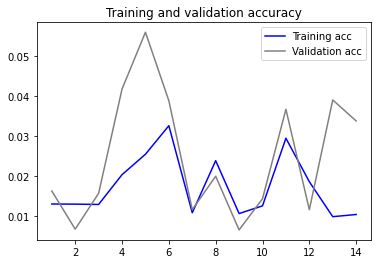

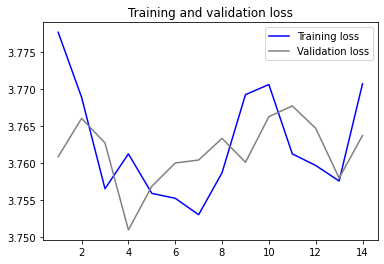

In [82]:
plot_results(history_lwm_model3)

2022-01-27 16:45:42.867963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[  0   0   0 ...   0   0  60]
 [  0   0   0 ...   0   0 720]
 [  0   0   0 ...   0   0 660]
 ...
 [  0   0   0 ...   0   0 450]
 [  0   0   0 ...   0   0 450]
 [  0   0   0 ...   0   0 480]]


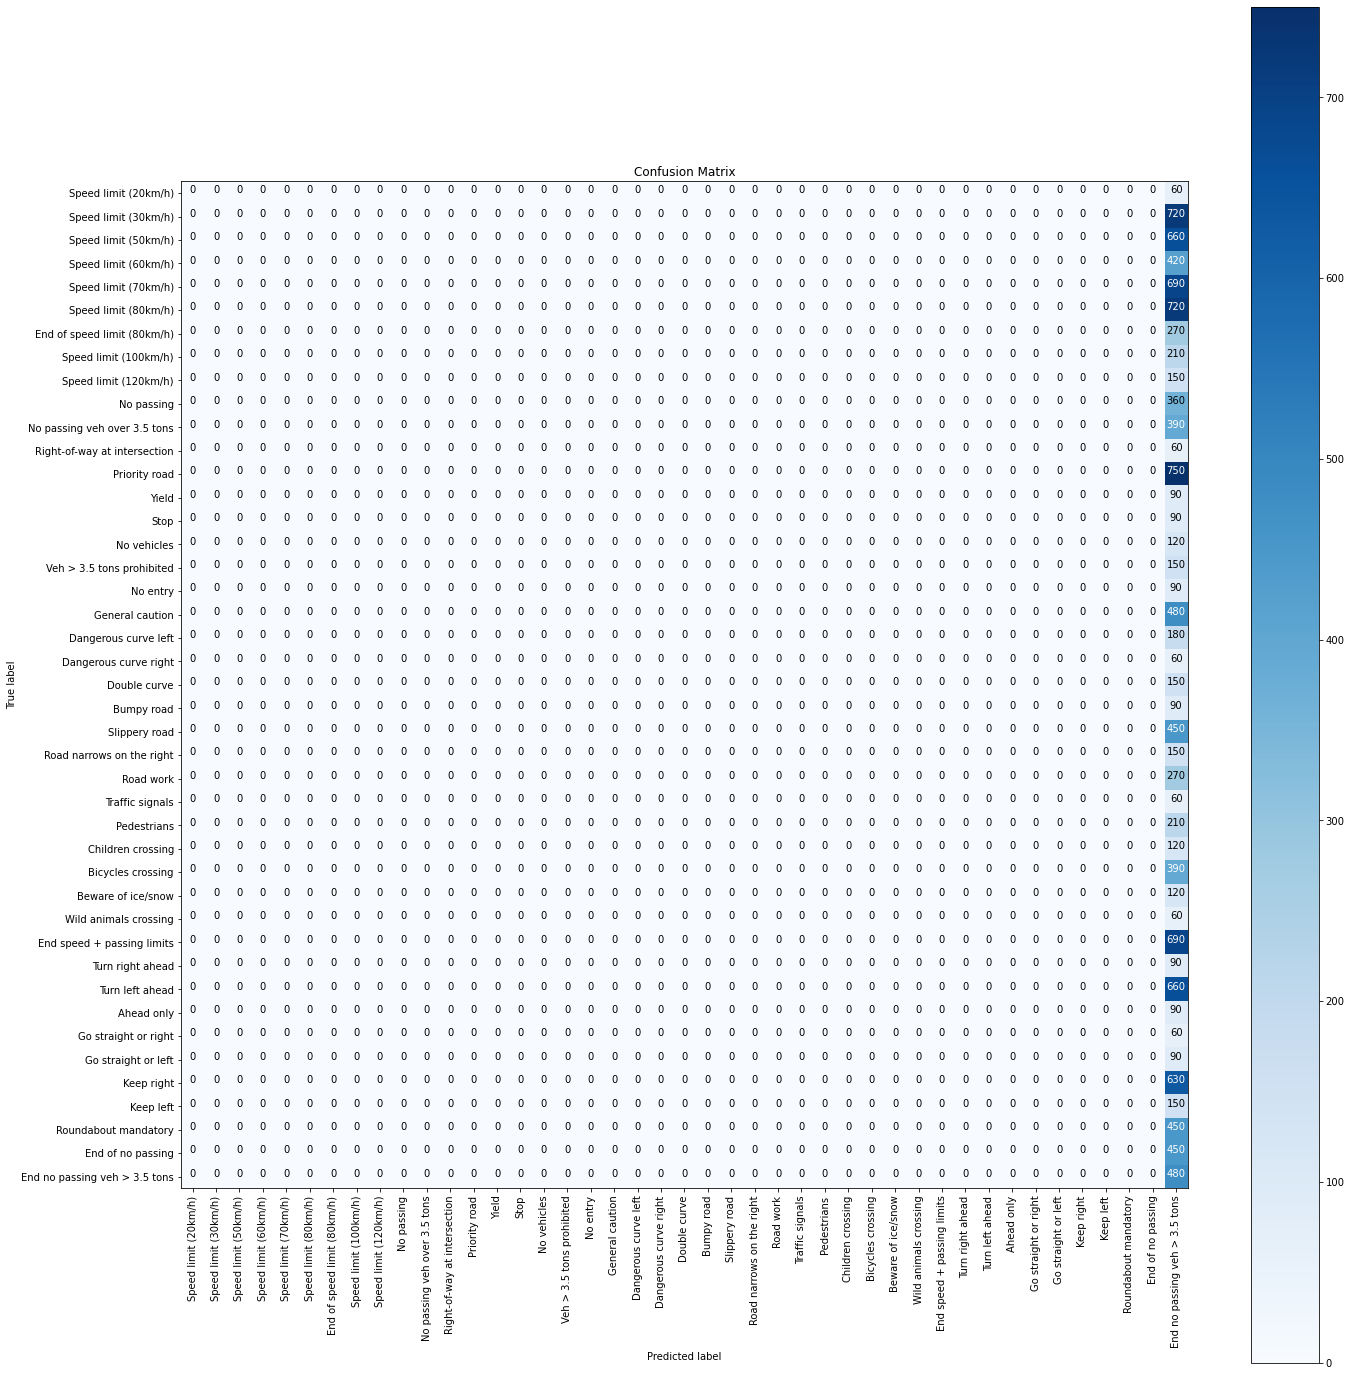

In [83]:
# predictions on Test data

Y_pred = lwm_model3.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [84]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00         0
         Speed limit (30km/h)       0.00      0.00      0.00         0
         Speed limit (50km/h)       0.00      0.00      0.00         0
         Speed limit (60km/h)       0.00      0.00      0.00         0
         Speed limit (70km/h)       0.00      0.00      0.00         0
         Speed limit (80km/h)       0.00      0.00      0.00         0
  End of speed limit (80km/h)       0.00      0.00      0.00         0
        Speed limit (100km/h)       0.00      0.00      0.00         0
        Speed limit (120km/h)       0.00      0.00      0.00         0
                   No passing       0.00      0.00      0.00         0
 No passing veh over 3.5 tons       0.00      0.00      0.00         0
 Right-of-way at intersection       0.00      0.00      0.00         0
                Priority road       0.00      0.00      0.00         0
     

/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Shape before entering the conv layer: (1, 64, 64, 3)


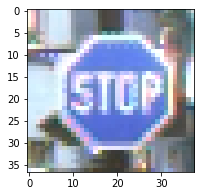

In [85]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 56, 56, 16)
(1, 28, 28, 16)
(1, 28, 28, 16)
(1, 24, 24, 16)
(1, 20, 20, 32)
(1, 10, 10, 32)
(1, 10, 10, 32)
(1, 6, 6, 64)
(1, 3, 3, 64)
(1, 576)
(1, 1024)
(1, 1024)
(1, 512)
(1, 512)
(1, 43)


2022-01-27 16:48:43.418299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: divide by zero encountered in true_divide
  x /= x.std()


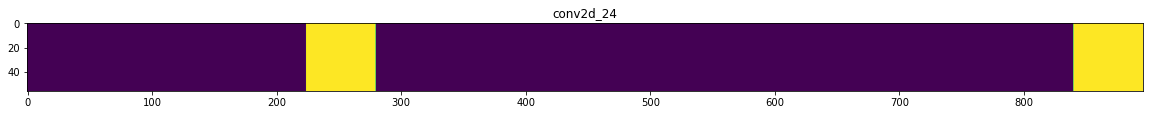

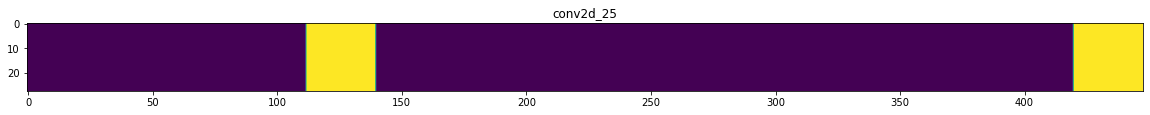

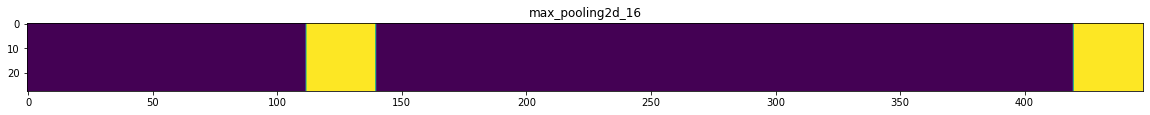

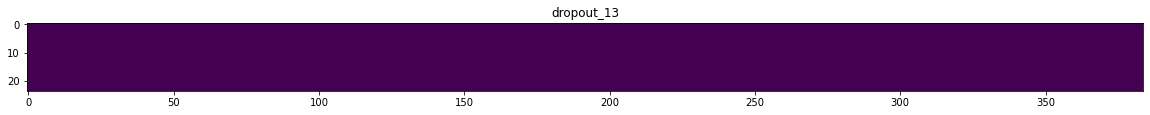

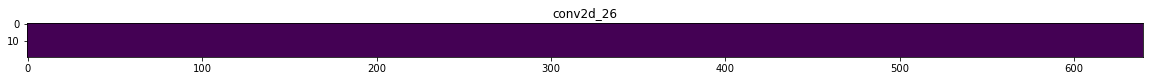

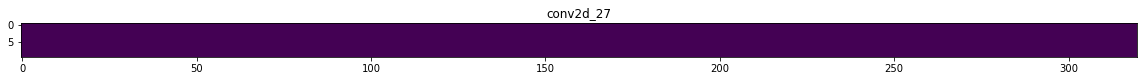

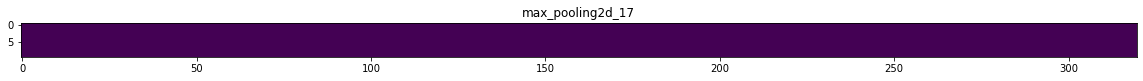

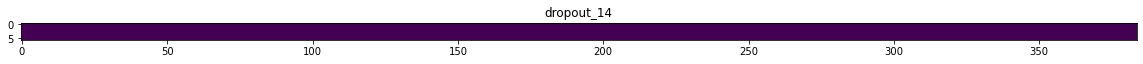

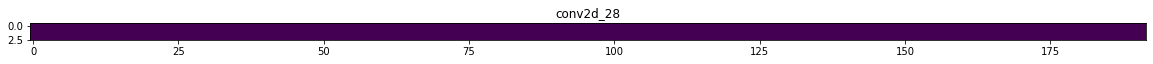

In [86]:
plot_feature_maps(lwm_model3, img)

## miniVGGNet


In [87]:
chanDim = -1
miniVGGmodel = Sequential()
# MLP - input layer
miniVGGmodel.add(Conv2D(8, (5, 5), activation = relu, padding="same", input_shape=(img_width, img_height, 3)))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Dense(units=cat_num, activation=softmax))

# Check built model:
miniVGGmodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 64, 64, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                      

In [88]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

miniVGGmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [89]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [91]:
# MLOps init and callback
wandb.init(name='CNN_TS_miniVGG_b256_e50_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_miniVGGmodel = miniVGGmodel.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100


2022-01-27 16:49:04.645832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 2.9291 - acc: 0.1736 - f1_score: 0.1793

2022-01-27 16:49:29.635171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 31s 293ms/step - loss: 2.9291 - acc: 0.1736 - f1_score: 0.1793 - val_loss: 2.8003 - val_acc: 0.2338 - val_f1_score: 0.2071
Epoch 2/100
100/100 [==============================] - 30s 295ms/step - loss: 1.8876 - acc: 0.3773 - f1_score: 0.3799 - val_loss: 2.0060 - val_acc: 0.3529 - val_f1_score: 0.3431
Epoch 3/100
100/100 [==============================] - 29s 292ms/step - loss: 1.4010 - acc: 0.5057 - f1_score: 0.5103 - val_loss: 1.6876 - val_acc: 0.4871 - val_f1_score: 0.4629
Epoch 4/100
100/100 [==============================] - 29s 294ms/step - loss: 1.1178 - acc: 0.5932 - f1_score: 0.5964 - val_loss: 1.1872 - val_acc: 0.6104 - val_f1_score: 0.6044
Epoch 5/100
100/100 [==============================] - 29s 290ms/step - loss: 0.9209 - acc: 0.6548 - f1_score: 0.6588 - val_loss: 1.2108 - val_acc: 0.6354 - val_f1_score: 0.6238
Epoch 6/100
100/100 [==============================] - 29s 290ms/step - loss: 0.7938 - acc: 0.6983 - f1_score: 0.7013 - va

/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


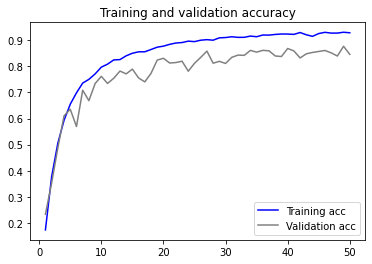

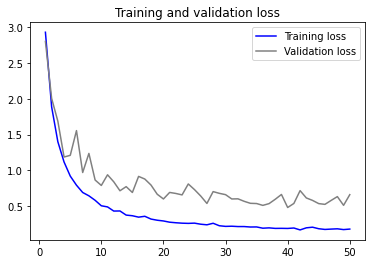

In [92]:
plot_results(history_miniVGGmodel)

2022-01-27 17:12:54.789753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[ 43  16   0 ...   0   0   0]
 [  1 677   0 ...   0   3   0]
 [  0   0 652 ...   0   0   1]
 ...
 [  1   3   2 ... 353  66   0]
 [  1   0   0 ...   2 431   0]
 [  0   0  39 ...   0   0 440]]


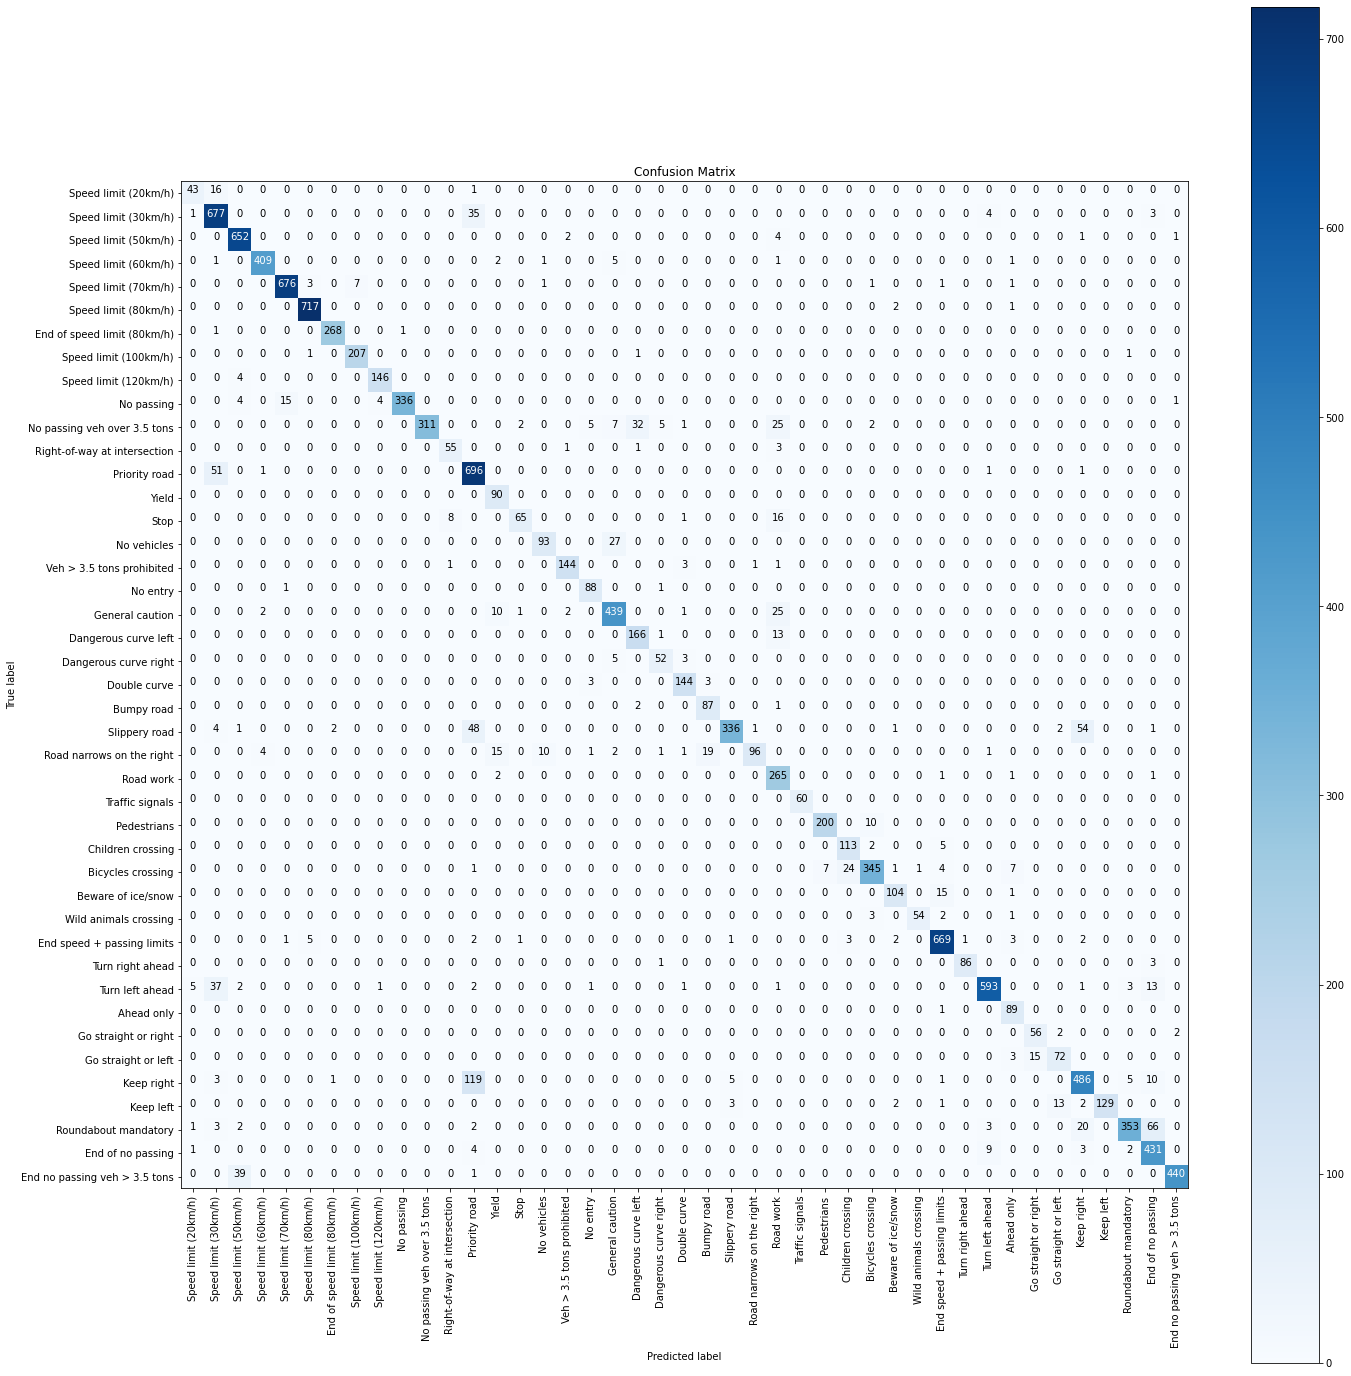

In [93]:
# predictions on Test data

Y_pred = miniVGGmodel.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [94]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.72      0.84      0.77        51
         Speed limit (30km/h)       0.94      0.85      0.89       793
         Speed limit (50km/h)       0.99      0.93      0.96       704
         Speed limit (60km/h)       0.97      0.98      0.98       416
         Speed limit (70km/h)       0.98      0.98      0.98       693
         Speed limit (80km/h)       1.00      0.99      0.99       726
  End of speed limit (80km/h)       0.99      0.99      0.99       271
        Speed limit (100km/h)       0.99      0.97      0.98       214
        Speed limit (120km/h)       0.97      0.97      0.97       151
                   No passing       0.93      1.00      0.96       337
 No passing veh over 3.5 tons       0.80      1.00      0.89       311
 Right-of-way at intersection       0.92      0.86      0.89        64
                Priority road       0.93      0.76      0.84       911
     

Shape before entering the conv layer: (1, 64, 64, 3)


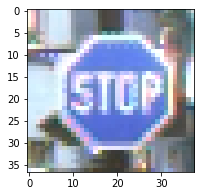

In [95]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

2022-01-27 17:13:11.432011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/st/bkqw7lsd1hzc7bk_lvgmq7p40000gn/T/ipykernel_1781/273602964.py:123: RuntimeWarning: divide by zero encountered in true_divide
  x /= x.std()


(1, 64, 64, 8)
(1, 32, 32, 8)
(1, 32, 32, 16)
(1, 32, 32, 16)
(1, 32, 32, 16)
(1, 32, 32, 16)
(1, 16, 16, 16)
(1, 4096)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 43)


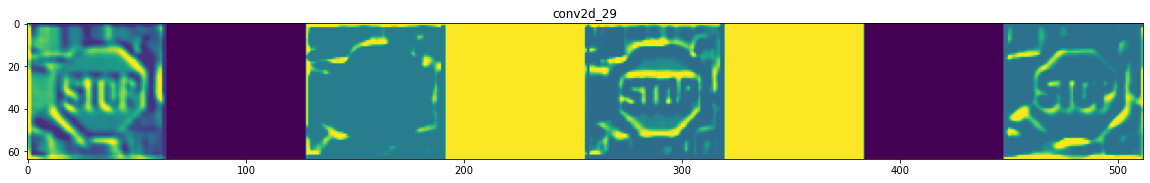

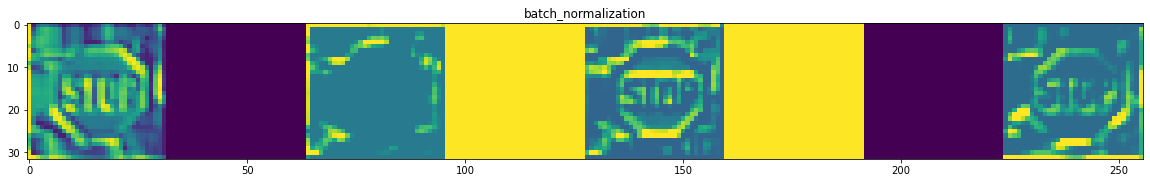

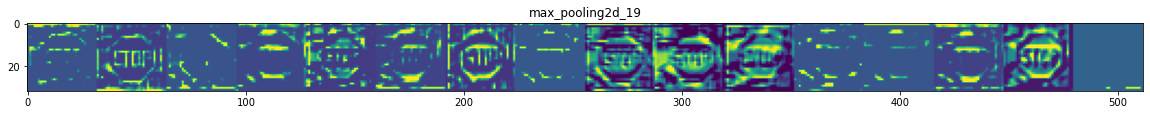

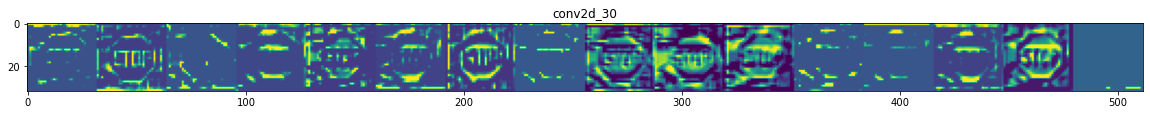

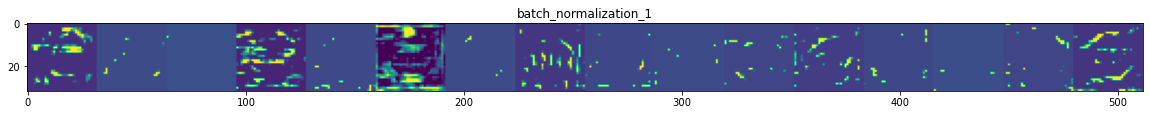

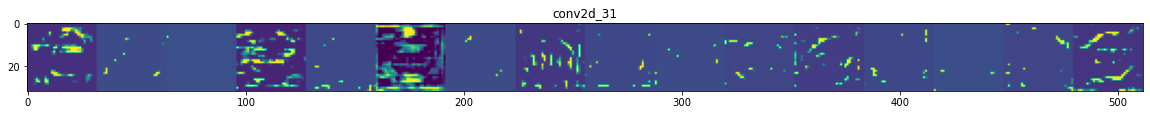

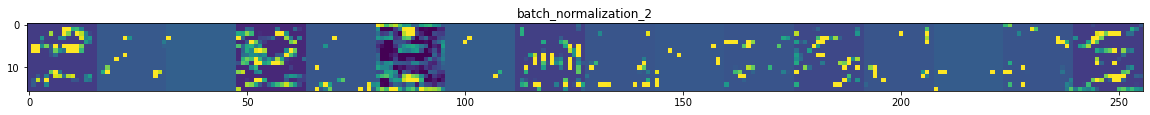

In [96]:
plot_feature_maps(miniVGGmodel, img)

8


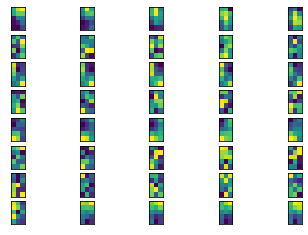

16


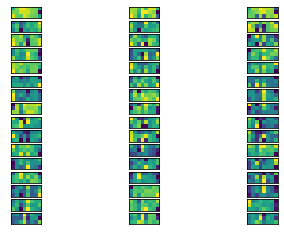

16


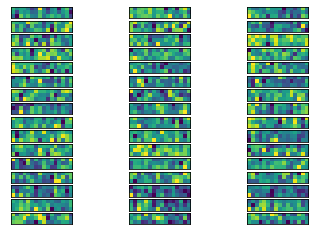

In [97]:
show_filters(miniVGGmodel)

# 